Silhouette Score: 0.0106
Kappa Score: 0.3638
NPMI Coherence: 0.1733

Top 10 words/collocations in Misclassified instances:
patient: 606
data: 401
study: 395
health: 326
method: 309
model: 264
based: 238
clinical: 228
using: 223
medical: 218


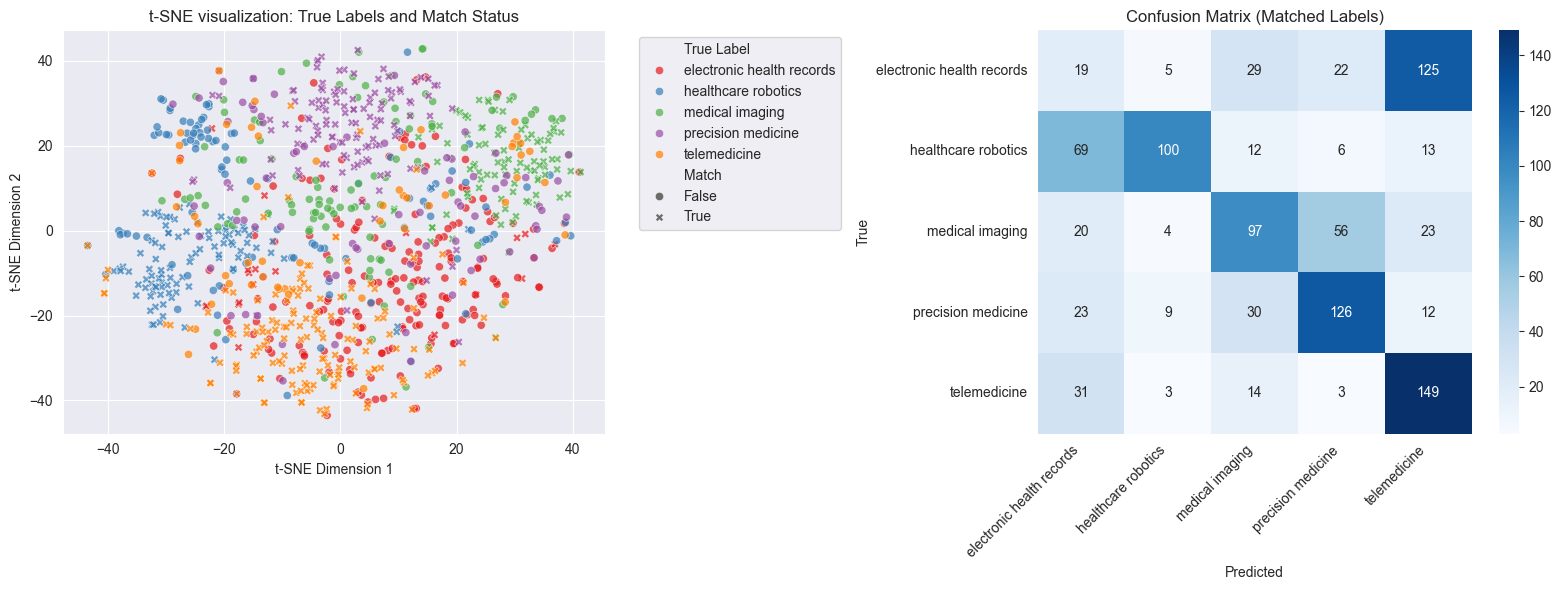

In [ ]:
import pandas as pd
import numpy as np
import itertools
import math
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, cohen_kappa_score, confusion_matrix
from scipy.optimize import linear_sum_assignment
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------- 1. Data Preprocessing and Feature Engineering -----------------
# Read data
df = pd.read_csv('../processed_data.csv')
# Remove meaningless 'pad' filler characters from text
docs = df['Cleaned_Content'].fillna('').str.replace(r'\bpad\b', '', regex=True).tolist()
true_labels = df['Label'].tolist()

# Get true label categories and mapping (K=5: EHR, Robotics, Imaging, Precision Medicine, Telemedicine)
unique_labels = sorted(list(set(true_labels)))
label_to_id = {l: i for i, l in enumerate(unique_labels)}
y_true = [label_to_id[l] for l in true_labels]

# TF-IDF Feature Engineering (Remove English stopwords, set frequency limits)
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', max_df=0.9, min_df=5)
X_tfidf = tfidf_vectorizer.fit_transform(docs)
feature_names = tfidf_vectorizer.get_feature_names_out()

# ----------------- 2. K-means Clustering -----------------
k = 5
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
y_pred_clusters = kmeans.fit_predict(X_tfidf)

# Since K-means generates random labels (0-4), use the Hungarian algorithm to find the optimal match between cluster labels and true labels
def match_labels(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    row_ind, col_ind = linear_sum_assignment(cm, maximize=True)
    mapping = {col: row for col, row in zip(col_ind, row_ind)}
    y_pred_matched = [mapping[l] for l in y_pred]
    return np.array(y_pred_matched), mapping, cm

y_pred_matched, cluster_mapping, cm = match_labels(y_true, y_pred_clusters)

# ----------------- 3. Model Evaluation -----------------
# 3.1 Silhouette Score (Measures clustering compactness and separation)
sil_score = silhouette_score(X_tfidf, y_pred_clusters)

# 3.2 Kappa Score (Measures consistency between clustering results and true labels)
kappa = cohen_kappa_score(y_true, y_pred_matched)

# 3.3 Coherence (Calculate topic coherence based on NPMI)
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
cluster_top_words = [[feature_names[ind] for ind in order_centroids[i, :10]] for i in range(k)]

cv_vectorizer = CountVectorizer(vocabulary=set([w for words in cluster_top_words for w in words]), binary=True)
X_binary = cv_vectorizer.fit_transform(docs).toarray()
word2id = cv_vectorizer.vocabulary_
N = len(docs)
coherence_scores = []

for top_words in cluster_top_words:
    score = 0
    pairs = list(itertools.combinations(top_words, 2))
    for w1, w2 in pairs:
        if w1 not in word2id or w2 not in word2id: continue
        id1, id2 = word2id[w1], word2id[w2]
        p_w1 = X_binary[:, id1].sum() / N
        p_w2 = X_binary[:, id2].sum() / N
        p_w12 = (X_binary[:, id1] * X_binary[:, id2]).sum() / N
        if p_w12 > 0:
            pmi = math.log(p_w12 / (p_w1 * p_w2))
            npmi = pmi / -math.log(p_w12)
            score += npmi
    coherence_scores.append(score / len(pairs) if pairs else 0)
avg_coherence = np.mean(coherence_scores)

print(f"Silhouette Score: {sil_score:.4f}")
print(f"Kappa Score: {kappa:.4f}")
print(f"NPMI Coherence: {avg_coherence:.4f}")

# ----------------- 4. Error Analysis -----------------
df['True_ID'] = y_true
df['Pred_ID'] = y_pred_matched
# Filter out misclassified samples
errors_df = df[df['True_ID'] != df['Pred_ID']]

# Extract the top 10 most frequent feature words and collocations (Unigrams & Bigrams) in misclassified samples
vectorizer_errors = CountVectorizer(stop_words='english', ngram_range=(1, 2))
X_errors = vectorizer_errors.fit_transform(errors_df['Cleaned_Content'].fillna('').str.replace(r'\bpad\b', '', regex=True))
error_sums = X_errors.sum(axis=0).tolist()[0]
error_freqs = [(word, error_sums[idx]) for word, idx in vectorizer_errors.vocabulary_.items()]
top_error_words = sorted(error_freqs, key=lambda x: x[1], reverse=True)[:10]

print("\nTop 10 words/collocations in Misclassified instances:")
for word, freq in top_error_words:
    print(f"{word}: {freq}")

# ----------------- 5. Visualizations -----------------
plt.figure(figsize=(16, 6))

# Plot 1: t-SNE dimensionality reduction scatter plot (View cluster boundaries and prediction correctness)
plt.subplot(1, 2, 1)
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_tfidf.toarray())
df_tsne = pd.DataFrame({
    't-SNE Dimension 1': X_tsne[:,0],
    't-SNE Dimension 2': X_tsne[:,1],
    'True Label': [unique_labels[i] for i in y_true],
    'Match': df['True_ID'] == df['Pred_ID']
})
sns.scatterplot(data=df_tsne, x='t-SNE Dimension 1', y='t-SNE Dimension 2', hue='True Label', style='Match', palette='Set1', alpha=0.7)
plt.title('t-SNE visualization: True Labels and Match Status')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot 2: Confusion Matrix (View specific misclassified categories)
plt.subplot(1, 2, 2)
sns.heatmap(confusion_matrix(y_true, y_pred_matched), annot=True, fmt='d', cmap='Blues',
            xticklabels=unique_labels, yticklabels=unique_labels)
plt.title('Confusion Matrix (Matched Labels)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('clustering_eval_clean.png', dpi=300)
plt.show()